# AIVLE스쿨 2차 미니프로젝트: 신규 아파트 주차 수요 예측

<img src = "https://github.com/Jangrae/img/blob/master/parking.png?raw=true" width=800, align="left"/>

# 단계 1: 데이터 전처리

## [미션]

단지별 등록 차량 수를 예측하기에 적합한 형태로 데이터 전처리를 수행합니다.

1) 필요한 변수를 추가하고 불필요한 변수를 제거합니다.
2) 단지별 데이터와 상세 데이터를 분리합니다.
3) 상세 데이터를 단지별로 집계합니다.
    - 단지별 총면적 집계
    - 전용면적구간 집계 (피벗형태)
    - 단지별 임대보증금, 임대료 평균 집계
4) 단지별 데이터와 집계 데이터를 하나로 합칩니다.
5) 변수 추가 (옵션)
    - 등록 차량수를 예측하기 위해 필요한 변수를 추가합니다.

## 1. 환경설정

### (1) 로컬 수행(Anaconda)

- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [31]:
# 기본 경로
path = ''

### (2) 구글 콜랩 수행

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [33]:
# 구글 드라이브 연결, 패스 지정
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'

### (3) 한글 폰트 표시용 라이브러리 설치

In [35]:
# 한글 표시를 위한 라이브러리 설치
#!pip install koreanize_matplotlib -q

### (4) 라이브러리 불러오기

In [37]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

import joblib
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (5) 데이터 불러오기

- 학습용 데이터(train.xlsx)를 읽어옵니다.
- 읽어온 데이터를 apart 데이터프레임으로 선언합니다.
- 평가용 데이터(test.xlsx) 파일은 모델 완성 후 사용할 미래의 데이터입니다.

#### 1) 데이터 불러오기

In [40]:
# 파일 불러오기
apart = pd.read_excel(path+'train.xlsx')

#### 2) 기본 정보 조회

In [42]:
apart.head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수
0,C0001,엘에이치 서초4단지,78,35,서울,20131204,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109
1,C0001,엘에이치 서초4단지,78,43,서울,20131204,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109
2,C0002,LH삼성아파트,35,26,서울,20130801,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35
3,C0002,LH삼성아파트,35,9,서울,20130801,복도식,개별가스난방,전체동 설치,47,29.08,17.3302,63062000,481560,35
4,C0003,강남LH8단지,88,7,서울,20131023,계단식,개별가스난방,전체동 설치,106,59.47,21.9462,72190000,586540,88


In [43]:
apart.isna().sum()

단지코드         0
단지명          0
총세대수         0
전용면적별세대수     0
지역           0
준공일자         0
건물형태        22
난방방식        75
승강기설치여부     98
단지내주차면수      0
전용면적         0
공용면적         0
임대보증금        0
임대료          0
실차량수         0
dtype: int64

In [44]:
apart.describe()

,총세대수,전용면적별세대수,준공일자,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수
count,1157.000000,1157.000000,1.157000e+03,1157.000000,1157.000000,1157.000000,1.157000e+03,1.157000e+03,1157.000000
mean,659.075194,163.691443,2.008667e+07,682.261884,51.565584,20.562360,2.850789e+07,2.259409e+05,650.762316
std,456.110643,166.766358,6.777985e+04,473.331805,18.243315,5.164405,2.890687e+07,1.768102e+05,390.573462
min,1.000000,1.000000,1.992010e+07,10.000000,17.590000,5.850000,0.000000e+00,0.000000e+00,21.000000
25%,315.000000,44.000000,2.005031e+07,308.000000,39.480000,16.997400,1.379700e+07,1.177400e+05,320.000000
50%,595.000000,112.000000,2.010042e+07,629.000000,46.900000,20.384700,1.997300e+07,1.842900e+05,626.000000
75%,918.000000,229.000000,2.013121e+07,911.000000,59.810000,23.722500,3.375300e+07,2.634400e+05,894.000000
max,2289.000000,1258.000000,2.022071e+07,4553.000000,139.350000,42.760000,2.549220e+08,1.058030e+06,1657.000000


<Axes: >

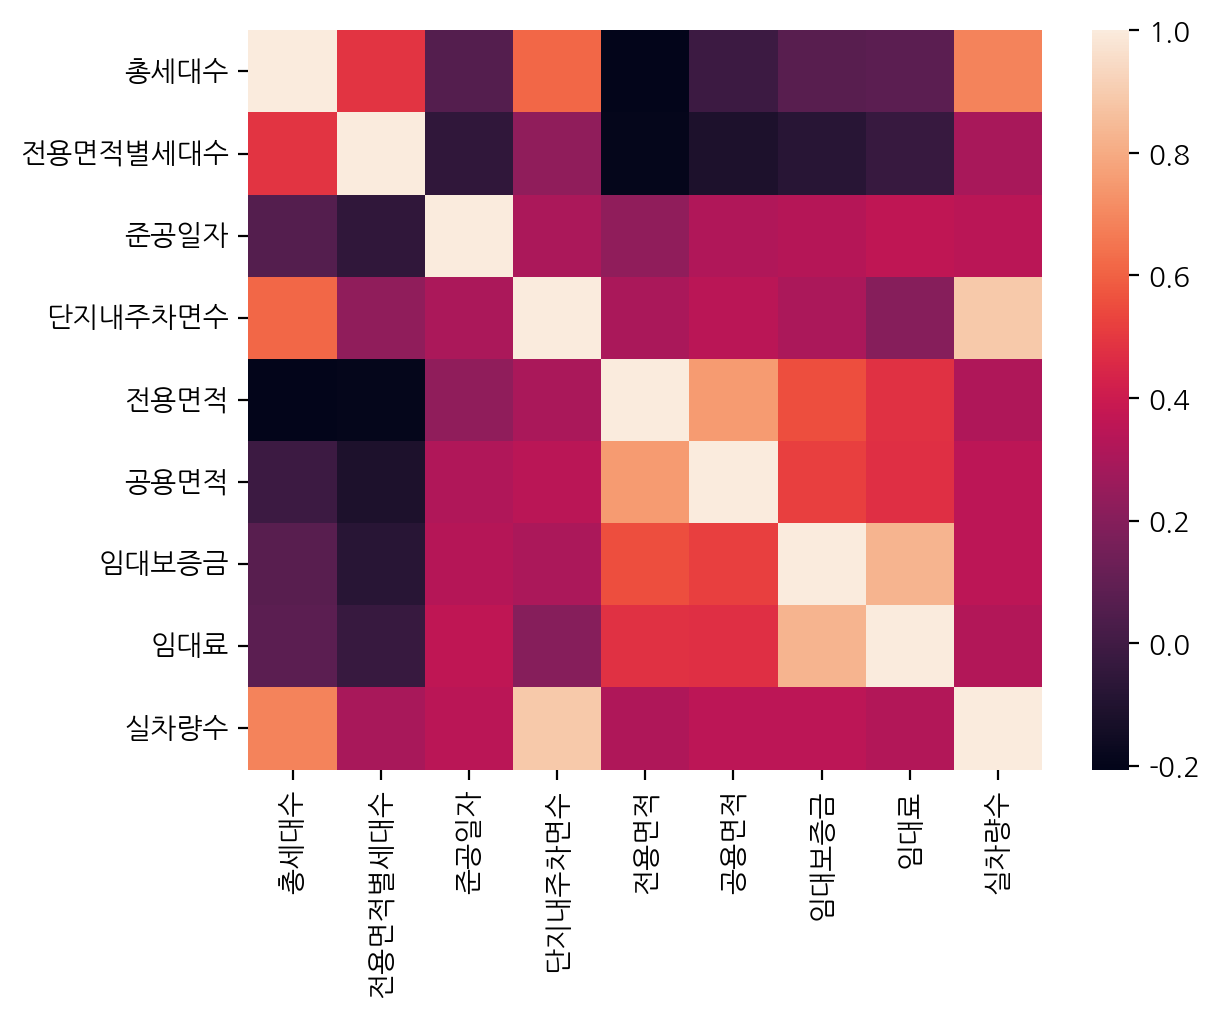

In [45]:
sns.heatmap(apart.corr(numeric_only=True))

## 2. 데이터 전처리 ①

- 결측치 존재 여부를 확인하고 적절히 처리합니다.
- 필요한 변수를 추가하고, 불필요한 변수를 제거합니다.

### (1) 결측치 처리

- 결측치가 있는 지 확인합니다.

In [48]:
apart.isna().sum()

단지코드         0
단지명          0
총세대수         0
전용면적별세대수     0
지역           0
준공일자         0
건물형태        22
난방방식        75
승강기설치여부     98
단지내주차면수      0
전용면적         0
공용면적         0
임대보증금        0
임대료          0
실차량수         0
dtype: int64

- 결측치는 적절한 값으로 채웁니다.
- 예를 들어 범주형 변수인 경우는 각 변수의 최빈값으로 채울 수 있습니다.

In [50]:
# 빈도수 계산
# apart['건물형태'].fillna(apart['건물형태'].mode()[0],inplace=True)
# apart['난방방식'].fillna(apart['난방방식'].mode()[0],inplace=True)
# apart['승강기설치여부'].fillna(apart['승강기설치여부'].mode()[0],inplace=True)

# apart.isna().sum()

# Xgbost를 통한 결측치 처리
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

def train_and_predict_missing_values(df, target_column):
    # 결측치가 있는 행과 없는 행으로 분리
    train_data = df[df[target_column].notnull()]
    test_data = df[df[target_column].isnull()]
    
    if len(test_data) == 0:
        return df  # 결측치가 없는 경우 예측할 필요가 없음
    
    # 변수 분리~
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    
    X_train_encoded = pd.get_dummies(X_train, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, drop_first=True)

    # 학습 데이터와 테스트 데이터의 열을 동일하게 맞춤
    X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)
    
    # 타겟 변수 레이블 인코딩
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    
    model = xgb.XGBClassifier()
    model.fit(X_train_encoded, y_train_encoded)

    y_pred_encoded = model.predict(X_test_encoded)
    
    y_pred = le.inverse_transform(y_pred_encoded)

    df.loc[df[target_column].isnull(), target_column] = y_pred
    return df

categorical_columns_with_nan = ['건물형태', '난방방식', '승강기설치여부']

for col in categorical_columns_with_nan:
    apart = train_and_predict_missing_values(apart, col)

print(apart)

       단지코드              단지명  총세대수  전용면적별세대수    지역      준공일자 건물형태    난방방식  \
0     C0001       엘에이치 서초4단지    78        35    서울  20131204  계단식  개별가스난방   
1     C0001       엘에이치 서초4단지    78        43    서울  20131204  계단식  개별가스난방   
2     C0002          LH삼성아파트    35        26    서울  20130801  복도식  개별가스난방   
3     C0002          LH삼성아파트    35         9    서울  20130801  복도식  개별가스난방   
4     C0003          강남LH8단지    88         7    서울  20131023  계단식  개별가스난방   
...     ...              ...   ...       ...   ...       ...  ...     ...   
1152  C0356       덕유마을 주공1단지   956       956    경기  19941130  복도식  지역가스난방   
1153  C0358  화천신읍(공공실버) 영구임대   120        66    강원  20200110  복도식  개별가스난방   
1154  C0358  화천신읍(공공실버) 영구임대   120        54    강원  20200110  복도식  개별가스난방   
1155  C0359            영천야사4   447       149  대구경북  19940615  복도식  중앙유류난방   
1156  C0359            영천야사4   447       298  대구경북  19940615  복도식  중앙유류난방   

     승강기설치여부  단지내주차면수   전용면적     공용면적     임대보증금     임대료  실차량수  
0     전체동 설

### (2) 변수 추가

- '준공일자' 변수 값 앞 4 자리를 갖는 int 형 변수 '준공연도'를 추가합니다.
- 총면적 = (전용면적 + 공용면적) * 전용면적별세대수 공식에 따른'총면적' 변수를 추가합니다.

In [52]:
apart['준공연도']=apart['준공일자']//10000
apart['총면적']=(apart['전용면적']+apart['공용면적'])*apart['전용면적별세대수']

apart.head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수,준공연도,총면적
0,C0001,엘에이치 서초4단지,78,35,서울,20131204,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109,2013,2490.2605
1,C0001,엘에이치 서초4단지,78,43,서울,20131204,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109,2013,3533.5078
2,C0002,LH삼성아파트,35,26,서울,20130801,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35,2013,1151.4750
3,C0002,LH삼성아파트,35,9,서울,20130801,복도식,개별가스난방,전체동 설치,47,29.08,17.3302,63062000,481560,35,2013,417.6918
4,C0003,강남LH8단지,88,7,서울,20131023,계단식,개별가스난방,전체동 설치,106,59.47,21.9462,72190000,586540,88,2013,569.9134


### (3) 불필요한 변수 제거

- '단지명' 변수는 단일값을 가지므로 제거합니다.
- '단지내주차면수' 변숫값을 기반으로 등록 차량수를 예측하는 것은 의미가 없으니, '단지내주차면수' 변수를 제거합니다.
- '준공연도' 변수를 추가했으니 '준공일자' 변수를 제거합니다.

In [54]:

apart.drop(columns='단지명',inplace=True)
apart.drop(columns='단지내주차면수',inplace=True)
apart.drop(columns='준공일자',inplace=True)

apart.head(20)

,단지코드,총세대수,전용면적별세대수,지역,건물형태,난방방식,승강기설치여부,전용면적,공용면적,임대보증금,임대료,실차량수,준공연도,총면적
0,C0001,78,35,서울,계단식,개별가스난방,전체동 설치,51.89,19.2603,50758000,620370,109,2013,2490.2605
1,C0001,78,43,서울,계단식,개별가스난방,전체동 설치,59.93,22.2446,63166000,665490,109,2013,3533.5078
2,C0002,35,26,서울,복도식,개별가스난방,전체동 설치,27.75,16.5375,63062000,458640,35,2013,1151.4750
3,C0002,35,9,서울,복도식,개별가스난방,전체동 설치,29.08,17.3302,63062000,481560,35,2013,417.6918
4,C0003,88,7,서울,계단식,개별가스난방,전체동 설치,59.47,21.9462,72190000,586540,88,2013,569.9134
5,C0003,88,6,서울,계단식,개별가스난방,전체동 설치,59.58,21.9868,72190000,586540,88,2013,489.4008
6,C0003,88,29,서울,계단식,개별가스난방,전체동 설치,59.60,21.9942,72190000,586540,88,2013,2366.2318
7,C0003,88,46,서울,계단식,개별가스난방,전체동 설치,59.62,22.0016,72190000,586540,88,2013,3754.5936
8,C0004,477,150,서울,복도식,지역난방,전체동 설치,59.96,21.5734,65421000,651960,943,2014,12230.0100
9,C0004,477,49,서울,복도식,지역난방,전체동 설치,74.89,26.9451,99261000,962150,943,2014,4989.9199


## 3. 데이터 전처리 ②

- 단지별 데이터와 상세 데이터로 분리합니다.
- 상세 데이터를 3가지 형태로 집계합니다.
- 단지별 데이터와 상세 데이터 집계 결과를 조인(Merge) 합니다.

### (1) 데이터 분리

- 단지별 데이터를 갖는 data01 데이터프레임을 선언합니다.
- 상세 데이터를 갖는 data02 데이터프레임을 선언합니다.

#### 1) 단지별 데이터 분리

- 다음 열을 갖는 data01 데이터프레임으로 선언합니다.
    - '단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수'
- data01 데이터프레임의 중복행을 제거합니다.
- 인덱스를 초기화 합니다. (단, 기존 인덱스 제거)
- 중복행 제거 여부를 필히 확인합니다.

In [58]:
data01=pd.DataFrame()
data01=apart.drop(columns=['총면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료'])
data01.head()

,단지코드,총세대수,지역,건물형태,난방방식,승강기설치여부,실차량수,준공연도
0,C0001,78,서울,계단식,개별가스난방,전체동 설치,109,2013
1,C0001,78,서울,계단식,개별가스난방,전체동 설치,109,2013
2,C0002,35,서울,복도식,개별가스난방,전체동 설치,35,2013
3,C0002,35,서울,복도식,개별가스난방,전체동 설치,35,2013
4,C0003,88,서울,계단식,개별가스난방,전체동 설치,88,2013


In [59]:
data01=data01.drop_duplicates()
data01.head(20)

,단지코드,총세대수,지역,건물형태,난방방식,승강기설치여부,실차량수,준공연도
0,C0001,78,서울,계단식,개별가스난방,전체동 설치,109,2013
2,C0002,35,서울,복도식,개별가스난방,전체동 설치,35,2013
4,C0003,88,서울,계단식,개별가스난방,전체동 설치,88,2013
8,C0004,477,서울,복도식,지역난방,전체동 설치,943,2014
14,C0006,15,서울,복도식,개별가스난방,전체동 설치,21,2013
20,C0007,69,부산울산,계단식,개별가스난방,전체동 설치,830,2014
23,C0008,86,부산울산,계단식,개별가스난방,전체동 설치,892,2011
25,C0009,39,부산울산,계단식,개별가스난방,전체동 설치,744,2007
27,C0010,26,부산울산,계단식,지역난방,전체동 설치,363,2012
28,C0011,46,부산울산,계단식,개별가스난방,전체동 설치,632,2007


In [60]:
data01.reset_index(drop=True,inplace=True)
data01.head()

,단지코드,총세대수,지역,건물형태,난방방식,승강기설치여부,실차량수,준공연도
0,C0001,78,서울,계단식,개별가스난방,전체동 설치,109,2013
1,C0002,35,서울,복도식,개별가스난방,전체동 설치,35,2013
2,C0003,88,서울,계단식,개별가스난방,전체동 설치,88,2013
3,C0004,477,서울,복도식,지역난방,전체동 설치,943,2014
4,C0006,15,서울,복도식,개별가스난방,전체동 설치,21,2013


#### 2) 상세 데이터 분리
    
- 다음 열을 갖는 data02 데이터프레임으로 선언합니다.
    - '단지코드', '총면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료'

In [62]:

data02=pd.DataFrame()
data02=apart.drop(columns=['총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수'])
data02.head()

,단지코드,전용면적별세대수,전용면적,공용면적,임대보증금,임대료,총면적
0,C0001,35,51.89,19.2603,50758000,620370,2490.2605
1,C0001,43,59.93,22.2446,63166000,665490,3533.5078
2,C0002,26,27.75,16.5375,63062000,458640,1151.4750
3,C0002,9,29.08,17.3302,63062000,481560,417.6918
4,C0003,7,59.47,21.9462,72190000,586540,569.9134


### (2) 상세 데이터 집계

- 앞에서 선언한 data02 데이터프레임을 대상으로 다음 3가지 형태로 집계합니다.
    - 단지코드별 총면적 합을 집계합니다.
    - 전용면적을 의미있는 구간으로 나누어 피벗 형태로 집계합니다.
    - 단지코드별 임대보증금, 임대료 평균을 집계합니다

#### 1) 단지코드별 총면적 합 집계

- 단지코드별 총면적 합을 집계합니다.
- 집계한 결과를 df_area 데이터프레임으로 선언합니다.

In [65]:
df_area=pd.DataFrame()
df_area=data02.groupby('단지코드',as_index=False)['총면적'].sum()

df_area.head()

,단지코드,총면적
0,C0001,6023.7683
1,C0002,1569.1668
2,C0003,7180.1396
3,C0004,47058.9273
4,C0006,543.0268


In [66]:
data02.head(20)

,단지코드,전용면적별세대수,전용면적,공용면적,임대보증금,임대료,총면적
0,C0001,35,51.89,19.2603,50758000,620370,2490.2605
1,C0001,43,59.93,22.2446,63166000,665490,3533.5078
2,C0002,26,27.75,16.5375,63062000,458640,1151.4750
3,C0002,9,29.08,17.3302,63062000,481560,417.6918
4,C0003,7,59.47,21.9462,72190000,586540,569.9134
5,C0003,6,59.58,21.9868,72190000,586540,489.4008
6,C0003,29,59.60,21.9942,72190000,586540,2366.2318
7,C0003,46,59.62,22.0016,72190000,586540,3754.5936
8,C0004,150,59.96,21.5734,65421000,651960,12230.0100
9,C0004,49,74.89,26.9451,99261000,962150,4989.9199


In [67]:
data02['전용면적'].min()

17.59

#### 2) 전용면적 구간별 집계 (피벗 형태)

- data02 데이터프레임에 전용면적을 몇몇 구간으로 나눈 범줏값을 갖는 변수를 추가합니다.
- 구간을 어떻게 나눌 지 충분히 고민해 봅니다.
    - 구간 예: 10-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-200 
- 추가할 변수 이름은 '전용면적구간'으로 합니다.
- 참고: pd.cut() 함수를 활용합니다.

In [69]:

# data02['전용면적구간']=pd.cut(data02['전용면적'],bins=[10,20,30,40,50,60,70,80,90,200],labels=['10','20','30','40','50','60','70','80','90'])
# data02.head()


import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns



area_data = data02[['전용면적']].values

k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
data02['군집'] = kmeans.fit_predict(area_data)

cluster_centers = np.sort(kmeans.cluster_centers_.flatten())

epsilon = 1
bins = np.insert(cluster_centers, 0, data02['전용면적'].min()-epsilon)
bins = np.append(bins, data02['전용면적'].max() + epsilon)

new_labels = [f'면적{int(bins[i])}_{int(bins[i+1])}' for i in range(len(bins)-1)]

data02['전용면적구간'] = pd.cut(data02['전용면적'], bins=bins, labels=new_labels, include_lowest=True, right=True)


- 단지코드, 전용면적구간별 전용면적별세대수 합을 집계합니다.
- 집계 결과를 temp 데이터프레임으로 선언합니다.

In [71]:
temp=data02.groupby(['단지코드','전용면적구간'],as_index=False)['전용면적별세대수'].sum()
temp.head()

,단지코드,전용면적구간,전용면적별세대수
0,C0001,면적16_26,0
1,C0001,면적26_38,0
2,C0001,면적38_46,0
3,C0001,면적46_51,0
4,C0001,면적51_59,35


- temp 데이터프레임을 피벗 형태로 변환하여 df_pivot 데이터프레임으로 선언합니다.
- 인덱스를 초기화합니다. (단, 인덱스였던 '단지코드'가 제거되면 안됨)
- 이후 작업의 편의를 위해 일반적인 데이터프레임 형태를 갖게 합니다.
- 참고: df2 = df1.pivot(index=?, columns=?, values=?) 형태로 pivot() 메서드를 사용합니다.
- 참고: df2.columns.name=None 형태의 구문을 사용해 열이름에 대한 이름을 제거합니다.

In [73]:
df_pivot=temp.pivot(index='단지코드',columns='전용면적구간',values='전용면적별세대수')


In [74]:
df_pivot.reset_index(inplace=True)
df_pivot.head()

전용면적구간,단지코드,면적16_26,면적26_38,면적38_46,면적46_51,면적51_59,면적59_74,면적74_85,면적85_127,면적127_140
0,C0001,0,0,0,0,35,43,0,0,0
1,C0002,0,35,0,0,0,0,0,0,0
2,C0003,0,0,0,0,88,0,0,0,0
3,C0004,0,0,0,0,0,199,278,0,0
4,C0006,14,1,0,0,0,0,0,0,0


#### 3) 임대보증금, 임대료 평균 집계

- 단지코드별 임대보증금, 임대료 평균을 집계합니다.
- 집계 결과를 df_rent 데이터프레임으로 선언합니다.

In [76]:
df_rent=data02.groupby("단지코드",as_index=False)[['임대보증금', '임대료']].mean()
df_rent.head()

,단지코드,임대보증금,임대료
0,C0001,5.696200e+07,642930.000000
1,C0002,6.306200e+07,470100.000000
2,C0003,7.219000e+07,586540.000000
3,C0004,1.015167e+08,950305.000000
4,C0006,5.522750e+07,340148.333333


### (3) 집계 결과 합치기

- 위 과정에서 만든 df_area, df_pivot, df_rent 데이터프레임을 data01 데이터프레임과 조인(Merge)합니다.
- data01 데이터프레임이 기준 데이터프레임입니다.
- '단지코드' 변수가 조인 기준이 되며, how='left'를 지정합니다.
- 조인 결과를 base_data 데이터프레임으로 선언합니다.

In [78]:
base_data=pd.merge(data01,df_area,how='left')
base_data=pd.merge(base_data,df_pivot,how='left')
base_data=pd.merge(base_data,df_rent,how='left')
base_data.head()

,단지코드,총세대수,지역,건물형태,난방방식,승강기설치여부,실차량수,준공연도,총면적,면적16_26,면적26_38,면적38_46,면적46_51,면적51_59,면적59_74,면적74_85,면적85_127,면적127_140,임대보증금,임대료
0,C0001,78,서울,계단식,개별가스난방,전체동 설치,109,2013,6023.7683,0,0,0,0,35,43,0,0,0,5.696200e+07,642930.000000
1,C0002,35,서울,복도식,개별가스난방,전체동 설치,35,2013,1569.1668,0,35,0,0,0,0,0,0,0,6.306200e+07,470100.000000
2,C0003,88,서울,계단식,개별가스난방,전체동 설치,88,2013,7180.1396,0,0,0,0,88,0,0,0,0,7.219000e+07,586540.000000
3,C0004,477,서울,복도식,지역난방,전체동 설치,943,2014,47058.9273,0,0,0,0,0,199,278,0,0,1.015167e+08,950305.000000
4,C0006,15,서울,복도식,개별가스난방,전체동 설치,21,2013,543.0268,14,1,0,0,0,0,0,0,0,5.522750e+07,340148.333333


## 4. 데이터 셋 저장

- joblib.dump() 함수를 사용하여 최종 데이터 셋을 파일로 저장합니다.
- 파일 이름은 base_data1.pkl로 합니다.

In [111]:
# 파일로 저장
joblib.dump(base_data, path+'base_data1.pkl')

['base_data1.pkl']